# Stress Prediction using ANN

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
path = '../../../data/03_primary/WESAD_preprocessed_int15_add15/combined_subjects.csv'
data = pd.read_csv(path, index_col=0)
data.head()

,net_acc_mean,net_acc_std,net_acc_min,net_acc_max,EDA_phasic_mean,EDA_phasic_std,EDA_phasic_min,EDA_phasic_max,EDA_smna_mean,EDA_smna_std,EDA_smna_min,EDA_smna_max,EDA_tonic_mean,EDA_tonic_std,EDA_tonic_min,EDA_tonic_max,BVP_mean,BVP_std,BVP_min,BVP_max,TEMP_mean,TEMP_std,TEMP_min,TEMP_max,ACC_x_mean,ACC_x_std,ACC_x_min,ACC_x_max,ACC_y_mean,ACC_y_std,ACC_y_min,ACC_y_max,ACC_z_mean,ACC_z_std,ACC_z_min,ACC_z_max,0_mean,0_std,0_min,0_max,BVP_peak_freq,TEMP_slope,subject,label
0,1.331891,0.153556,1.014138,1.678399,2.247876,1.112076,0.367977,4.459367,1.592308,2.645333,3.096902e-08,17.418821,0.608263,1.212010,-1.213173,2.554750,-0.043934,112.391233,-392.28,554.77,35.816000,0.017436,35.77,35.87,0.024658,0.018284,-0.037843,0.087383,0.000017,0.000013,-0.000026,0.000060,0.000017,0.000013,-0.000026,0.000060,0.027558,0.013523,0.000000,0.087383,0.080556,-0.000102,2,1
1,1.218994,0.090108,1.014138,1.485800,1.781323,1.203991,0.232625,4.459367,1.347750,2.666659,3.096902e-08,17.418821,0.731985,1.171627,-1.213173,2.477276,-1.189267,120.431399,-392.28,554.77,35.796111,0.029522,35.75,35.87,0.020313,0.019242,-0.037843,0.087383,0.000014,0.000013,-0.000026,0.000060,0.000014,0.000013,-0.000026,0.000060,0.023420,0.015310,0.000000,0.087383,0.144444,-0.000424,2,1
2,1.143312,0.110987,0.948835,1.485800,1.173169,1.285422,0.006950,4.459367,0.752335,1.958546,3.096902e-08,17.418821,1.110242,1.112268,-1.213173,2.037179,0.280427,87.571000,-357.53,371.12,35.763056,0.044673,35.68,35.87,0.016618,0.015316,-0.021330,0.071558,0.000011,0.000011,-0.000015,0.000049,0.000011,0.000011,-0.000015,0.000049,0.018759,0.012604,0.000000,0.071558,0.102778,-0.000814,2,1
3,1.020669,0.135308,0.811090,1.239944,0.311656,0.278650,0.006950,1.303071,0.198576,0.413802,3.309991e-08,2.788862,1.598995,0.350355,0.959752,2.037179,0.055833,68.797466,-345.19,359.57,35.725000,0.033491,35.66,35.81,0.022681,0.012560,-0.006881,0.054356,0.000016,0.000009,-0.000005,0.000037,0.000016,0.000009,-0.000005,0.000037,0.022888,0.012180,0.000688,0.054356,0.108333,-0.000524,2,1
4,0.887458,0.116048,0.727406,1.125306,0.163826,0.110277,0.006950,0.369298,0.118080,0.237575,2.787285e-08,1.300810,1.342085,0.405980,0.945946,2.037179,0.096681,43.606312,-289.26,209.89,35.701333,0.022420,35.66,35.75,0.028105,0.010415,0.002752,0.054356,0.000019,0.000007,0.000002,0.000037,0.000019,0.000007,0.000002,0.000037,0.028105,0.010415,0.002752,0.054356,0.147222,-0.000165,2,1


In [3]:
pd.set_option('display.max_rows', 10)

### Data Preparation

#### Merged amusement
First we will merge the amusement data with the baseline data as after the EDA we found out that they are very simmilar.

In [4]:
data_merged_am = data.copy()
data_merged_am["label"] = data_merged_am["label"].replace([0], 1)
data_merged_am["label"].unique()

array([1, 2], dtype=int64)

Now we will split the data into train, validation and test sets.

In [5]:
X = data_merged_am[["EDA_smna_mean", "EDA_phasic_min", "EDA_tonic_mean", "EDA_tonic_min", "EDA_tonic_max"]]
y = data_merged_am["label"]

X_train, X_test, y_train_merged_am, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training (1337 samples) and 20% test (334 samples)
X_val, X_test, y_val_merged_am, y_test_merged_am = train_test_split(X_test, y_test, test_size=0.1, random_state=42) # 90% of test set is used for validation (301 samples) and 10% for testing (33 samples)

We also need to scale the data so it lies between 0 and 1. This is important because the NN algorithm works better with scaled data, as generally activation function use values between 0 and 1.

In [6]:
scaler = MinMaxScaler()
X_train_merged_am = scaler.fit_transform(X_train)
X_val_merged_am = scaler.transform(X_val)
X_test_merged_am = scaler.transform(X_test)

#### Dropped amusement
First we will drop the amusement data to see if merging it with baseline confuses the algorithm.

In [7]:
data_no_am = data.copy()
data_no_am = data_no_am[data_no_am["label"] != 0]
data_merged_am["label"].unique()

array([1, 2], dtype=int64)

Now we will again split the data into train, validation and test sets and scale it.

In [8]:
X = data_no_am[['net_acc_std', 'net_acc_max', 'EDA_tonic_mean', 'EDA_tonic_min', 'EDA_tonic_max']]
y = data_no_am["label"]

X_train, X_test, y_train_no_am, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% test
X_val, X_test, y_val_no_am, y_test_no_am = train_test_split(X_test, y_test, test_size=0.1, random_state=42) # 90% of test set is used for validationand 10% for testing

scaler = MinMaxScaler()
X_train_no_am = scaler.fit_transform(X_train)
X_val_no_am = scaler.transform(X_val)
X_test_no_am = scaler.transform(X_test)

### Modeling and Training

We will create a function that will create, compile and train a model so we can easily try different models and compare them. We will use the Sequential model from Keras, which is a linear stack of layers. We will add the Dense layers, which are just regular densely connected NN layers. The last layer will have 3 neurons (the number of labels) by default. We will use the relu activation function for the hidden layers and the softmax activation function for the last one. The softmax function is used for multiclass classification problems, it returns the probability of each class.

In [9]:
def build_model(neurons_per_layer=[64, 64], n_outputs=3):
    model = Sequential()

    for i in range(len(neurons_per_layer)):
            model.add(Dense(neurons_per_layer[i], activation='relu'))

    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#### Merged amusement
In order to decide for how many epochs we will train the model, we will devide the lenght of the dataset by the batch size and multiply it by two. This will give us a good estimate of how many epochs we need to train the model.

In [10]:
batch_size = 32
len(y_train_merged_am) / batch_size * 2

104.5

The first model we will create will behave two layers with 64 neurons each. We will train for 20 epochs and use a standard batch size of 32.

In [11]:
model1 = build_model()
history1 = model1.fit(x=X_train_merged_am, y=y_train_merged_am, epochs=100, validation_data=(X_val_merged_am, y_val_merged_am))

Epoch 1/100
53/53 [==============================] - 1s 7ms/step - loss: 0.8352 - accuracy: 0.6645 - val_loss: 0.6165 - val_accuracy: 0.7241
Epoch 2/100
53/53 [==============================] - 0s 3ms/step - loss: 0.5494 - accuracy: 0.7207 - val_loss: 0.4378 - val_accuracy: 0.8806
Epoch 3/100
53/53 [==============================] - 0s 3ms/step - loss: 0.3942 - accuracy: 0.8756 - val_loss: 0.2898 - val_accuracy: 0.9178
Epoch 4/100
53/53 [==============================] - 0s 3ms/step - loss: 0.3005 - accuracy: 0.9001 - val_loss: 0.2432 - val_accuracy: 0.9284
Epoch 5/100
53/53 [==============================] - 0s 3ms/step - loss: 0.2724 - accuracy: 0.9079 - val_loss: 0.2196 - val_accuracy: 0.9257
Epoch 6/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2607 - accuracy: 0.9055 - val_loss: 0.2126 - val_accuracy: 0.9231
Epoch 7/100
53/53 [==============================] - 0s 3ms/step - loss: 0.2565 - accuracy: 0.9049 - val_loss: 0.2118 - val_accuracy: 0.9257
Epoch 8/100
5

We will also try models with 2 layers of 128 nodes and 3 layers with 1 layer of 64 and 2 layers of 128 nodes. We will again train for 20 epochs and use a standard batch size of 32.

In [12]:
model2 = build_model([128, 128])
history2 = model2.fit(x=X_train_merged_am, y=y_train_merged_am, epochs=100, validation_data=(X_val_merged_am, y_val_merged_am))

Epoch 1/100
53/53 [==============================] - 1s 6ms/step - loss: 0.6682 - accuracy: 0.7004 - val_loss: 0.4429 - val_accuracy: 0.7745
Epoch 2/100
53/53 [==============================] - 0s 3ms/step - loss: 0.3773 - accuracy: 0.8714 - val_loss: 0.2540 - val_accuracy: 0.9151
Epoch 3/100
53/53 [==============================] - 0s 3ms/step - loss: 0.2761 - accuracy: 0.9043 - val_loss: 0.2186 - val_accuracy: 0.9231
Epoch 4/100
53/53 [==============================] - 0s 3ms/step - loss: 0.2612 - accuracy: 0.9031 - val_loss: 0.2129 - val_accuracy: 0.9231
Epoch 5/100
53/53 [==============================] - 0s 3ms/step - loss: 0.2605 - accuracy: 0.9019 - val_loss: 0.2221 - val_accuracy: 0.9204
Epoch 6/100
53/53 [==============================] - 0s 3ms/step - loss: 0.2560 - accuracy: 0.9007 - val_loss: 0.2105 - val_accuracy: 0.9204
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.2577 - accuracy: 0.9055 - val_loss: 0.2054 - val_accuracy: 0.9151
Epoch 8/100
5

In [13]:
model3 = build_model([512, 256, 256])
history3 = model3.fit(x=X_train_merged_am, y=y_train_merged_am, epochs=100, validation_data=(X_val_merged_am, y_val_merged_am))

Epoch 1/100
53/53 [==============================] - 1s 8ms/step - loss: 0.4909 - accuracy: 0.8002 - val_loss: 0.2168 - val_accuracy: 0.9204
Epoch 2/100
53/53 [==============================] - 0s 5ms/step - loss: 0.2728 - accuracy: 0.8917 - val_loss: 0.2130 - val_accuracy: 0.9151
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.2613 - accuracy: 0.8947 - val_loss: 0.2223 - val_accuracy: 0.9072
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 0.2715 - accuracy: 0.8900 - val_loss: 0.2228 - val_accuracy: 0.9045
Epoch 5/100
53/53 [==============================] - 0s 4ms/step - loss: 0.2464 - accuracy: 0.8989 - val_loss: 0.1997 - val_accuracy: 0.9231
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.2532 - accuracy: 0.9007 - val_loss: 0.1917 - val_accuracy: 0.9204
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.2388 - accuracy: 0.9037 - val_loss: 0.2028 - val_accuracy: 0.9257
Epoch 8/100
5

#### Dropped amusement

We will train the same models as the ones we trained with the merged data.

In [14]:
batch_size = 32
len(y_train_no_am) / batch_size * 2

88.0

In [15]:
model1_no_am = build_model()
history1_no_am = model1_no_am.fit(x=X_train_no_am, y=y_train_no_am, epochs=100, validation_data=(X_val_no_am, y_val_no_am))

Epoch 1/100
44/44 [==============================] - 1s 8ms/step - loss: 0.7757 - accuracy: 0.6506 - val_loss: 0.5698 - val_accuracy: 0.7690
Epoch 2/100
44/44 [==============================] - 0s 5ms/step - loss: 0.4999 - accuracy: 0.7947 - val_loss: 0.4068 - val_accuracy: 0.8703
Epoch 3/100
44/44 [==============================] - 0s 6ms/step - loss: 0.3884 - accuracy: 0.8487 - val_loss: 0.3460 - val_accuracy: 0.8797
Epoch 4/100
44/44 [==============================] - 0s 5ms/step - loss: 0.3546 - accuracy: 0.8551 - val_loss: 0.3062 - val_accuracy: 0.8797
Epoch 5/100
44/44 [==============================] - 0s 5ms/step - loss: 0.3439 - accuracy: 0.8558 - val_loss: 0.2939 - val_accuracy: 0.8892
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 0.3348 - accuracy: 0.8587 - val_loss: 0.2977 - val_accuracy: 0.8829
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 0.3317 - accuracy: 0.8643 - val_loss: 0.2835 - val_accuracy: 0.8956
Epoch 8/100
4

In [16]:
model2_no_am = build_model([128, 128])
history2_no_am = model2_no_am.fit(x=X_train_no_am, y=y_train_no_am, epochs=100, validation_data=(X_val_no_am, y_val_no_am))

Epoch 1/100
44/44 [==============================] - 1s 8ms/step - loss: 0.6864 - accuracy: 0.6882 - val_loss: 0.4498 - val_accuracy: 0.8259
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 0.4033 - accuracy: 0.8452 - val_loss: 0.3170 - val_accuracy: 0.8766
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 0.3453 - accuracy: 0.8615 - val_loss: 0.2929 - val_accuracy: 0.8987
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 0.3338 - accuracy: 0.8608 - val_loss: 0.2881 - val_accuracy: 0.9051
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 0.3297 - accuracy: 0.8693 - val_loss: 0.2811 - val_accuracy: 0.8987
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 0.3322 - accuracy: 0.8651 - val_loss: 0.2803 - val_accuracy: 0.8924
Epoch 7/100
44/44 [==============================] - 0s 4ms/step - loss: 0.3261 - accuracy: 0.8651 - val_loss: 0.2861 - val_accuracy: 0.8861
Epoch 8/100
4

In [17]:
model3_no_am = build_model([512, 256, 256])
history3_no_am = model3_no_am.fit(x=X_train_no_am, y=y_train_no_am, epochs=100, validation_data=(X_val_no_am, y_val_no_am))

Epoch 1/100
44/44 [==============================] - 1s 10ms/step - loss: 0.5204 - accuracy: 0.7955 - val_loss: 0.2961 - val_accuracy: 0.8892
Epoch 2/100
44/44 [==============================] - 0s 4ms/step - loss: 0.3542 - accuracy: 0.8530 - val_loss: 0.2811 - val_accuracy: 0.9019
Epoch 3/100
44/44 [==============================] - 0s 4ms/step - loss: 0.3310 - accuracy: 0.8629 - val_loss: 0.2901 - val_accuracy: 0.8703
Epoch 4/100
44/44 [==============================] - 0s 4ms/step - loss: 0.3279 - accuracy: 0.8551 - val_loss: 0.2681 - val_accuracy: 0.8924
Epoch 5/100
44/44 [==============================] - 0s 4ms/step - loss: 0.3202 - accuracy: 0.8636 - val_loss: 0.2645 - val_accuracy: 0.8892
Epoch 6/100
44/44 [==============================] - 0s 4ms/step - loss: 0.3272 - accuracy: 0.8615 - val_loss: 0.2682 - val_accuracy: 0.8861
Epoch 7/100
44/44 [==============================] - 0s 4ms/step - loss: 0.3122 - accuracy: 0.8615 - val_loss: 0.2508 - val_accuracy: 0.9051
Epoch 8/100


### Evaluation 
In order to compare the three models we will plot the loss and accuracy of all of them.

In [18]:
def plot_evaluation(eval_type='accuracy', histories=[], labels=[]):
    fig, axs = plt.subplots(ncols=2, figsize=(16,5))
    for i in range(len(histories)):
        axs[0].plot(histories[i].history[eval_type])
        axs[1].plot(histories[i].history['val_' + eval_type])

    for ax in axs.flat:
        ax.set(xlabel='Epoch', ylabel=eval_type)
        ax.legend(labels, loc='upper left')

    fig.suptitle(f'Model train and validation {eval_type}')

#### Merged amusement

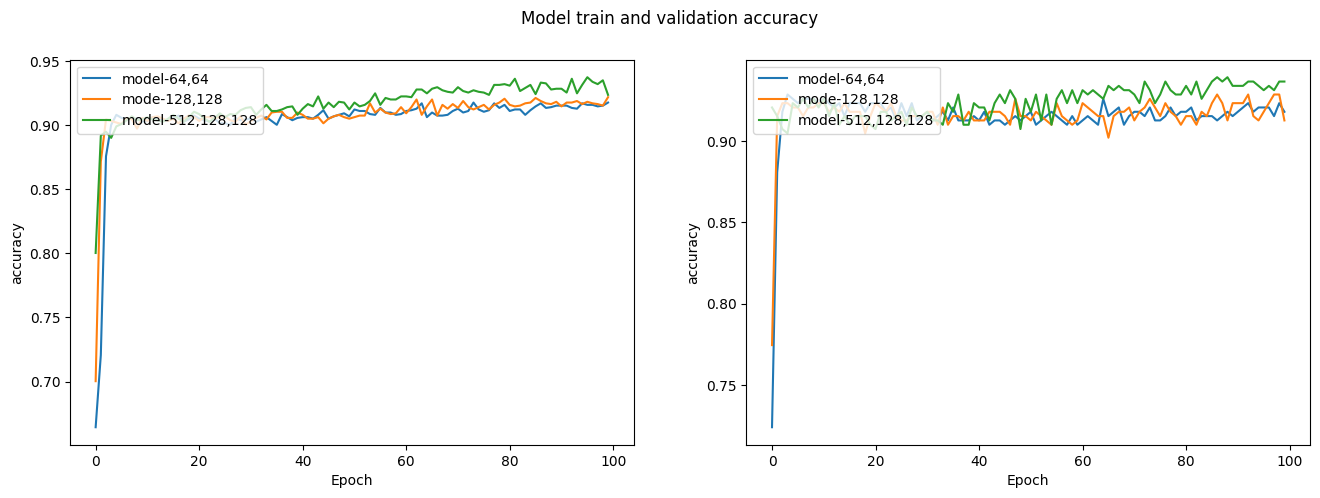

In [19]:
results = [history1, history2, history3]
labels = ['model-64,64', 'mode-128,128', 'model-512,128,128']
plot_evaluation('accuracy', results, labels)

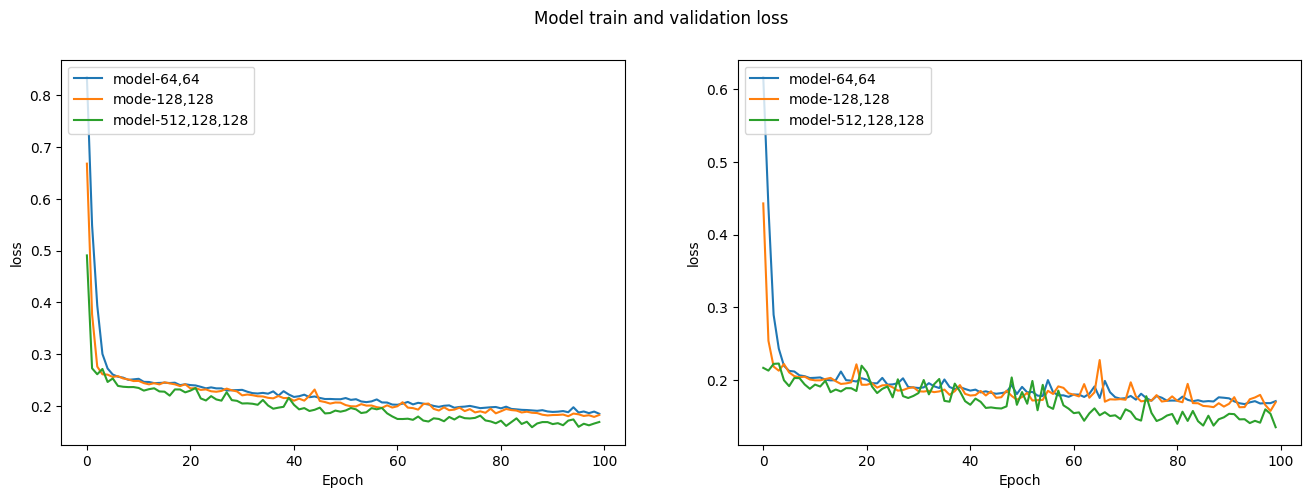

In [20]:
plot_evaluation('loss', results, labels)

We can conclude that the model with 3 layers of 512, 128 and 128 nodes in each layer is the best model. It has a loss of ~0.15 and accuracy of ~93%. We can also see that the model is not overfitting as the loss and accuracy of the validation set are very close to the ones of the training set. Now we will plot a confusion matrix to see how the model performs on each class.

12/12 [==============================] - 0s 2ms/step


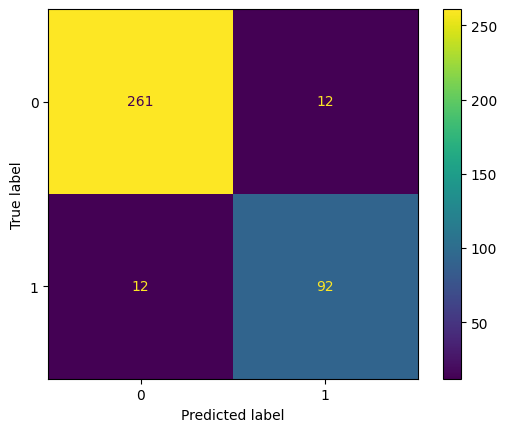

In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

y_pred_merged_am = model3.predict(X_val_merged_am)
cm = confusion_matrix(y_val_merged_am, y_pred_merged_am.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [22]:
print(f"f1_score: {round(f1_score(y_val_merged_am, y_pred_merged_am.argmax(axis=1)), 3)}")
print(f"recall_score: {round(recall_score(y_val_merged_am, y_pred_merged_am.argmax(axis=1)), 3)}")
print(f"precision_score: {round(precision_score(y_val_merged_am, y_pred_merged_am.argmax(axis=1)), 3)}")

f1_score: 0.956
recall_score: 0.956
precision_score: 0.956


We can see that less than 4% of the data is misclassified. And the recall and precission of the model are very balanced.

#### Dropped amusement

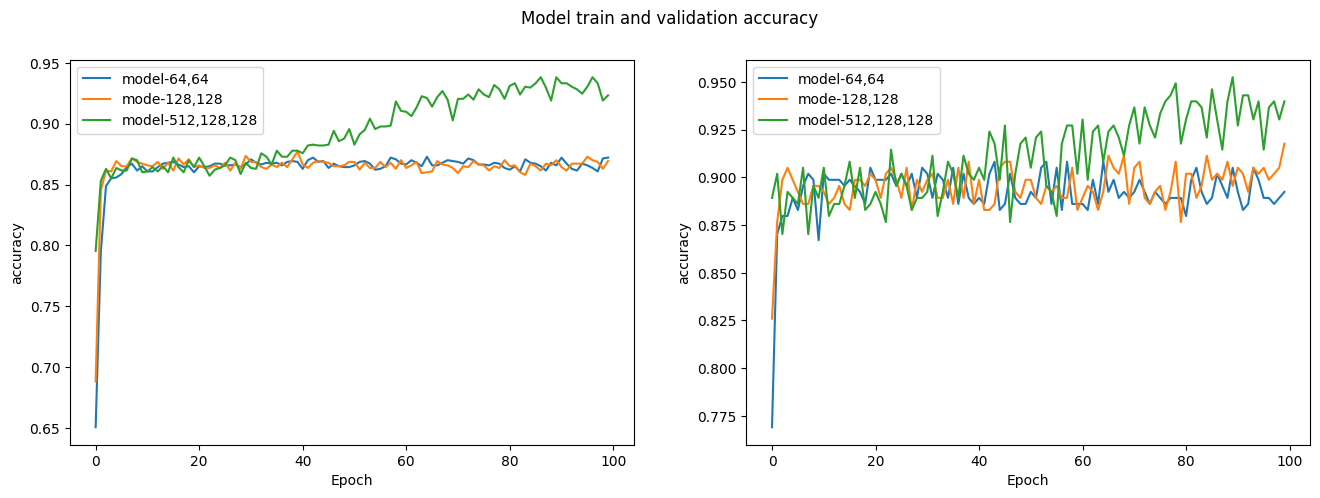

In [23]:
results_ = [history1_no_am, history2_no_am, history3_no_am]
labels_ = ['model-64,64', 'mode-128,128', 'model-512,128,128']
plot_evaluation('accuracy', results_, labels_)

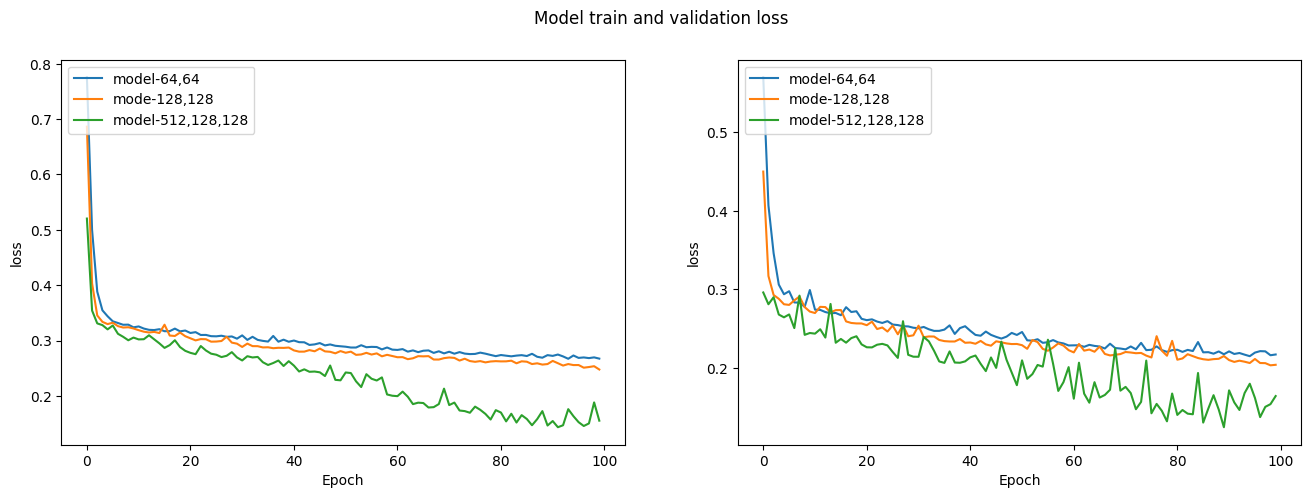

In [24]:
plot_evaluation('loss', results_, labels_)

We can conclude that the model with 3 layers of 512, 128 and 128 nodes in each layer is the best model. It has a loss of ~0.1 and accuracy of ~94%. We can also see that the model is not overfitting as the loss and accuracy of the validation set are very close to the ones of the training set. Now we will again plot a confusion matrix to see how the model performs on each class.

10/10 [==============================] - 0s 2ms/step


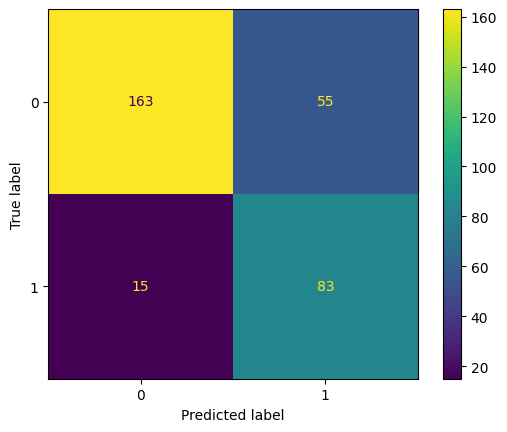

In [25]:
y_pred_no_am = model3.predict(X_val_no_am)
cm = confusion_matrix(y_val_no_am, y_pred_no_am.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [26]:
predictions = y_pred_no_am.argmax(axis=1)
print(f"f1_score: {round(f1_score(y_val_no_am, predictions), 3)}")
print(f"recall_score: {round(recall_score(y_val_no_am, predictions), 3)}")
print(f"precision_score: {round(precision_score(y_val_no_am, predictions), 3)}")

f1_score: 0.823
recall_score: 0.748
precision_score: 0.916


We can see that after predicting the validation data the accuracy is pretty low at 80%. Additionally, in contrast with the `merged amusement` model, the `no amusement` model has much higher recall than precission with more than 15% difference.